In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from allantools import adev
from scipy.signal import welch
import os

%matplotlib inline

In [3]:
def read_file(fn,path):
    """ Reads AOM phase chirp data, returns a dataframe"""
    #get sampling rate
    file_path = path + fn
    #row 0 is metadata
    meta_row = pd.read_csv(file_path,nrows=1,header=None).iloc[0]
    meta = [x.split('=')[-1] for x in meta_row]
    frame_size, sampling_rate, carrier = int(meta[0]),float(meta[1]),float(meta[2])
    
    df = pd.read_csv(file_path,skiprows=1)
    ts = np.linspace(0,(frame_size-1)*(1e6/sampling_rate),frame_size)
    df['ts/us'] = ts 
    df = df.set_index('ts/us')

    #df['amplitude'] = [float(x) for x in df['amplitude']]
    #df['phase/rad'] = [float(x) for x in df['phase/rad']]
    
    return df

In [10]:
df = read_file('220103_151306_aoms_on_benchmark.csv','220103_benchmark/')
#df = read_file('220103_151215_PD_input_benchmark.csv','220103_benchmark/')

Linear fit the phase

In [11]:
phase_linFit = curve_fit(lambda x,m,c: m*x+c, df.index, np.array(df['phase/rad']))
df['phase-linFit/rad'] = df['phase/rad'] - df.index*phase_linFit[0][0]

Time Series

In [108]:
ax1.autoscale?

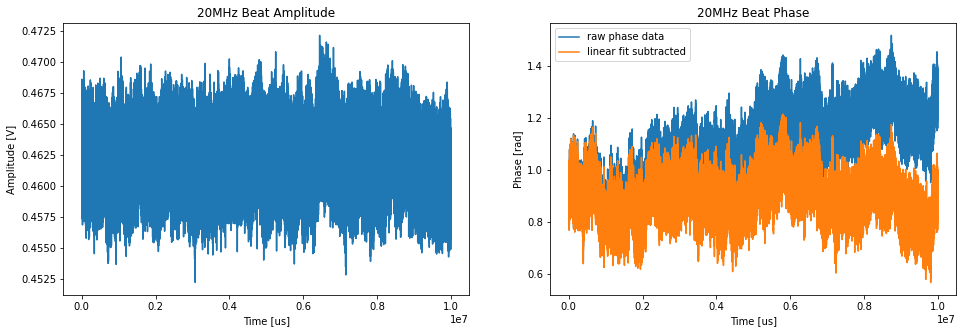

In [116]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(16,5),sharex=True)
ax0.plot(df['amplitude'])
ax0.set_title('20MHz Beat Amplitude')
ax0.set_xlabel('Time [us]')
ax0.set_ylabel('Amplitude [V]')
ax1.plot(df['phase/rad'],label='raw phase data')
ax1.plot(df['phase-linFit/rad'],label='linear fit subtracted')
ax1.legend()
ax1.set_ylabel('Phase [rad]')
ax1.set_xlabel('Time [us]')
ax1.set_title('20MHz Beat Phase')
#plt.savefig('220103_20MHz_beat_10s.jpg',dpi=150)
plt.show()

In [104]:
lines?

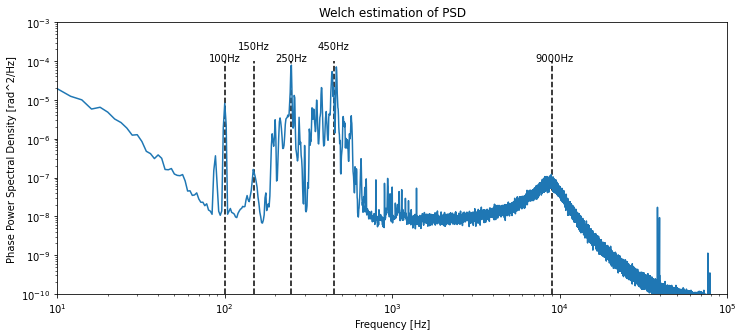

In [134]:
#get the one-sided power spectral density
ts = df.index[1]-df.index[0]
fs = 1/(ts*1e-6)
segment_length = len(df) / 20 #arbitrary
f, sxx = welch(np.array(df['phase-linFit/rad']),fs,nperseg=segment_length)

plt.figure(figsize=(12,5))
lines_x = [100,150,250,450,9000]
plt.vlines(lines_x,1e-10,1e-4,color='k',ls='--')
plt.plot(f,sxx)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10,100000)
plt.ylim(1e-10,1e-3)
plt.ylabel('Phase Power Spectral Density [rad^2/Hz]')
plt.xlabel('Frequency [Hz]')
plt.title('Welch estimation of PSD')
for i,x in enumerate(lines_x):
    plt.text(0.8*x,(1+i%2)*1e-4,str(x)+'Hz')
#plt.savefig('220103_phase_10s_psd.jpg',dpi=150)
plt.show()

Amplitude Stability

In [37]:
amps = np.array(df['amplitude'])
taus = np.logspace(-5,0,100)
DATA_RATE = 200e3
amps_adev = adev(amps,rate=DATA_RATE,data_type='freq',taus=taus)

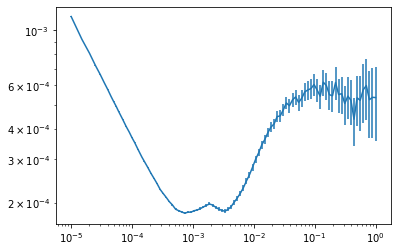

In [46]:
plt.errorbar(*amps_adev[:3])
plt.yscale('log')
plt.xscale('log')

In [60]:
phase = np.array(df['phase-linFit/rad'])
taus = np.logspace(-5,0,100)
DATA_RATE = 200e3
phase_adev = adev(phase,rate=DATA_RATE,data_type='freq',taus=taus)

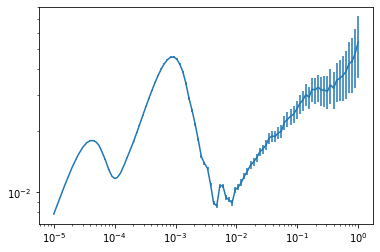

In [61]:
plt.errorbar(*phase_adev[:3])
plt.yscale('log')
plt.xscale('log')

In [42]:
plt.errorbar?

Notes

In [25]:
pd.read_csv('220103_benchmark/220103_151332_aoms_on_benchmark.csv',nrows=1,header=None)

,0,1,2
0,frame_size = 2000000,actual_sampling_rate/(S/sec) = 200000.000000,carrier/Hz = 19999999.9953
